In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from ucr import *
from models import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [52]:
task = 'Adiac'

In [53]:
# DATAPATH = Path.cwd()/'Univariate_arff' #if not Adiac
DATAPATH = Path.cwd()

In [54]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.git'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.gitignore'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.ipynb_checkpoints'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.vscode'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-inception.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/02_adiac_inception_resnet.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/README.md'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/__pycache__'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/dev_merge.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/dev_nbs'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/download

In [55]:
df_train, df_test = load_df(DATAPATH, task)

Loading files from: /home/tc256760/Documents/TimeSeries_fastai/Adiac


In [56]:
num_classes = df_train.target.nunique(); num_classes

37

# DL

In [57]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [58]:
x_train.shape, x_test.shape

((390, 176), (391, 176))

In [59]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [62]:
bs = max_bs(len(tr_ds)); bs

32

In [63]:
db = create_databunch(tr_ds, val_ds, bs)

Testing dims at input/output

## Resnet 1D

In [70]:
tx, ty = next(iter(db.train_dl))
print(tx.shape, ty.shape)

torch.Size([32, 1, 176]) torch.Size([32])


In [71]:
# model = create_resnet(1, num_classes, conv_sizes=[64, 128, 256], stride=1)

In [72]:
model = create_mlp(x_train[0].shape[0], num_classes)

In [73]:
# model = create_fcn(1, num_classes)

In [74]:
model

Sequential(
  (0): Flatten()
  (1): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=176, out_features=500, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=500, out_features=500, bias=True)
  (8): ReLU(inplace=True)
  (9): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=500, out_features=500, bias=True)
  (12): ReLU(inplace=True)
  (13): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.2, inplace=False)
  (15): Linear(in_features=500, out_features=37, bias=True)
)

Sanity check

In [77]:
model.cuda()(tx).shape  #should be (bs, num_classes)

torch.Size([32, 37])

In [69]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


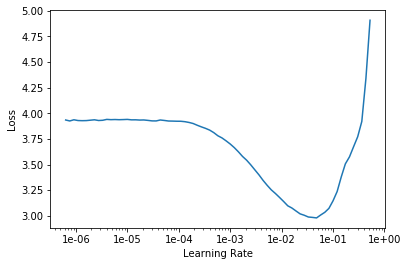

In [21]:
learn_res.lr_find(); learn_res.recorder.plot()

In [23]:
learn_res.fit_one_cycle(40, 5e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.435443,1.483845,0.366921,00:00
1,1.516080,0.711866,0.174046,00:00
2,0.989930,0.524560,0.177099,00:00
3,0.795682,0.513879,0.177608,00:00
4,0.757448,0.554152,0.179135,00:00
5,0.776508,0.633539,0.210687,00:00
6,0.827521,0.610802,0.188295,00:00
7,0.848001,0.705214,0.231552,00:00
8,0.794026,0.531333,0.165394,00:00
9,0.740811,0.653032,0.190331,00:00


In [35]:
err = torch.stack([t[0] for t in learn_res.recorder.metrics]).min()  

In [36]:
err

tensor(0.2037)

In [33]:
p, t = learn_res.get_preds()

In [34]:
error_rate(p,t)

tensor(0.2778)

In [30]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

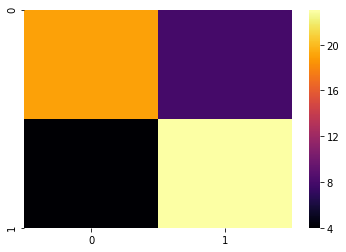

In [31]:
sns.heatmap(get_cm(p,t), cmap='inferno')